In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sklearn.model_selection as ms
import numpy as np
import scipy.io as sio
import math


# Author: Haoming Zhang
# The code here not only include data importing,
# but also data standardization and the generation of analog noise signals


def get_rms(records):
    # rms is root mean square
    return math.sqrt(sum([x ** 2 for x in records]) / len(records))


def random_signal(signal, combin_num):
    # Random disturb and augment signal
    random_result = []

    for i in range(combin_num):
        random_num = np.random.permutation(signal.shape[0])

        shuffled_dataset = signal[random_num, :]
        shuffled_dataset = shuffled_dataset.reshape(signal.shape[0], signal.shape[1])

        random_result.append(shuffled_dataset)

    random_result = np.array(random_result)

    return random_result



def data_prepare(EEG_all, noise_all, combin_num, train_num, test_num):
    # The code here not only include data importing,
    # but also data standardization and the generation of analog noise signals

    eeg_train, eeg_test = EEG_all[0:train_num, :], EEG_all[train_num:train_num + test_num, :]
    noise_train, noise_test = noise_all[0:train_num, :], noise_all[train_num:train_num + test_num, :]


    EEG_train = random_signal(eeg_train, combin_num).reshape(combin_num * eeg_train.shape[0], eeg_train.shape[1])
    NOISE_train = random_signal(noise_train, combin_num).reshape(combin_num * noise_train.shape[0],
                                                                 noise_train.shape[1])

    # print(EEG_train.shape)
    # print(NOISE_train.shape)

    #################################  simulate noise signal of training set  ##############################

    # create random number between -10dB ~ 2dB
    # SNR is signal-to-noise ratio
    SNR_train_dB = np.random.uniform(-7, 2, (EEG_train.shape[0]))
    # print(SNR_train_dB.shape)
    SNR_train = 10 ** (0.1 * (SNR_train_dB))

    # combin eeg and noise for training set
    noiseEEG_train = []
    NOISE_train_adjust = []
    for i in range(EEG_train.shape[0]):
        eeg = EEG_train[i].reshape(EEG_train.shape[1])
        noise = NOISE_train[i].reshape(NOISE_train.shape[1])

        coe = get_rms(eeg) / (get_rms(noise) * SNR_train[i])
        noise = noise * coe
        neeg = noise + eeg

        NOISE_train_adjust.append(noise)
        noiseEEG_train.append(neeg)

    noiseEEG_train = np.array(noiseEEG_train)
    NOISE_train_adjust = np.array(NOISE_train_adjust)

    # variance for noisy EEG
    EEG_train_end_standard = []
    noiseEEG_train_end_standard = []

    for i in range(noiseEEG_train.shape[0]):
        # Each epochs divided by the standard deviation
        eeg_train_all_std = EEG_train[i] / np.std(noiseEEG_train[i])
        EEG_train_end_standard.append(eeg_train_all_std)

        noiseeeg_train_end_standard = noiseEEG_train[i] / np.std(noiseEEG_train[i])
        noiseEEG_train_end_standard.append(noiseeeg_train_end_standard)

    noiseEEG_train_end_standard = np.array(noiseEEG_train_end_standard)
    EEG_train_end_standard = np.array(EEG_train_end_standard)

    #################################  simulate noise signal of test  ##############################

    SNR_test_dB = np.linspace(-7.0, 2.0, num=(10))
    SNR_test = 10 ** (0.1 * (SNR_test_dB))

    eeg_test = np.array(eeg_test)
    noise_test = np.array(noise_test)

    # combin eeg and noise for test set
    EEG_test = []
    noise_EEG_test = []
    for i in range(10):

        noise_eeg_test = []
        for j in range(eeg_test.shape[0]):
            eeg = eeg_test[j]
            noise = noise_test[j]

            coe = get_rms(eeg) / (get_rms(noise) * SNR_test[i])
            noise = noise * coe
            neeg = noise + eeg

            noise_eeg_test.append(neeg)

        EEG_test.extend(eeg_test)
        noise_EEG_test.extend(noise_eeg_test)

    noise_EEG_test = np.array(noise_EEG_test)
    EEG_test = np.array(EEG_test)

    # std for noisy EEG
    EEG_test_end_standard = []
    noiseEEG_test_end_standard = []
    std_VALUE = []
    for i in range(noise_EEG_test.shape[0]):
        # store std value to restore EEG signal
        std_value = np.std(noise_EEG_test[i])
        std_VALUE.append(std_value)

        # Each epochs of eeg and neeg was divide by the standard deviation
        eeg_test_all_std = EEG_test[i] / std_value
        EEG_test_end_standard.append(eeg_test_all_std)

        noiseeeg_test_end_standard = noise_EEG_test[i] / std_value
        noiseEEG_test_end_standard.append(noiseeeg_test_end_standard)

    std_VALUE = np.array(std_VALUE)
    noiseEEG_test_end_standard = np.array(noiseEEG_test_end_standard)
    EEG_test_end_standard = np.array(EEG_test_end_standard)

    # In order to facilitate the training and application of neural networks,
    # normalized the noisy EEG signal

    return noiseEEG_train_end_standard, EEG_train_end_standard, noiseEEG_test_end_standard, EEG_test_end_standard, std_VALUE


In [3]:

import os

epochs = 1  # training epoch
batch_size = 1000  # training batch size
train_num = 3000  # how many trails for train
test_num = 400  # how many trails for test


combin_num = 10  # combin EEG and noise ? times


EEG_all = np.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/eeg_3400.npy')
EOG_all = np.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/eog_3400.npy')
EMG_all = np.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/emg_3400.npy')

EOGEEG_train_input, EOGEEG_train_output, EOGEEG_test_input, EOGEEG_test_output, test_std_VALUE = data_prepare(EEG_all, EOG_all, combin_num,
                                                                                  train_num, test_num)

EMGEEG_train_input, EMGEEG_train_output, EMGEEG_test_input, EMGEEG_test_output, test_std_VALUE = data_prepare(EEG_all, EMG_all, combin_num,
                                                                                  train_num, test_num)

train_input = np.vstack((EOGEEG_train_input, EMGEEG_train_input))
train_output = np.vstack((EOGEEG_train_output, EMGEEG_train_output))
test_input = np.vstack((EOGEEG_test_input, EMGEEG_test_input))
test_output = np.vstack((EOGEEG_test_output, EMGEEG_test_output))

np.save('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/train_input.npy', train_input)
np.save('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/train_output.npy', train_output)
np.save('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/test_input.npy', test_input)
np.save('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/test_output.npy', test_output)

np.save('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/EOG_EEG_test_input.npy', EOGEEG_test_input)
np.save('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/EOG_EEG_test_output.npy', EOGEEG_test_output)
np.save('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/EMG_EEG_test_input.npy', EMGEEG_test_input)
np.save('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/EMG_EEG_test_output.npy', EMGEEG_test_output)



In [4]:
import torch
import torch.nn as nn


class DeepSeparator(nn.Module):

    def __init__(self):
        super(DeepSeparator, self).__init__()

        self.conv1_1_1 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=3, padding=1)
        self.conv1_1_2 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=5, padding=2)
        self.conv1_1_3 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=11, padding=5)
        self.conv1_1_4 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=15, padding=7)

        self.conv1_2_1 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=3, padding=1)
        self.conv1_2_2 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=5, padding=2)
        self.conv1_2_3 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=11, padding=5)
        self.conv1_2_4 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=15, padding=7)

        self.conv1_3_1 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=3, padding=1)
        self.conv1_3_2 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=5, padding=2)
        self.conv1_3_3 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=11, padding=5)
        self.conv1_3_4 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=15, padding=7)

        self.conv1_4_1 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=3, padding=1)
        self.conv1_4_2 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=5, padding=2)
        self.conv1_4_3 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=11, padding=5)
        self.conv1_4_4 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=15, padding=7)

        self.conv1_squeeze1 = nn.Conv1d(in_channels=20, out_channels=1, kernel_size=1)

        '''--------------------------------------------------------------------------------'''

        self.conv2_1_1 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=3, padding=1)
        self.conv2_1_2 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=5, padding=2)
        self.conv2_1_3 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=11, padding=5)
        self.conv2_1_4 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=15, padding=7)

        self.conv2_2_1 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=3, padding=1)
        self.conv2_2_2 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=5, padding=2)
        self.conv2_2_3 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=11, padding=5)
        self.conv2_2_4 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=15, padding=7)

        self.conv2_3_1 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=3, padding=1)
        self.conv2_3_2 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=5, padding=2)
        self.conv2_3_3 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=11, padding=5)
        self.conv2_3_4 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=15, padding=7)

        self.conv2_4_1 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=3, padding=1)
        self.conv2_4_2 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=5, padding=2)
        self.conv2_4_3 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=11, padding=5)
        self.conv2_4_4 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=15, padding=7)

        self.conv1_squeeze2 = nn.Conv1d(in_channels=20, out_channels=1, kernel_size=1)

        '''--------------------------------------------------------------------------------'''

        self.conv3_1_1 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=3, padding=1)
        self.conv3_1_2 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=5, padding=2)
        self.conv3_1_3 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=11, padding=5)
        self.conv3_1_4 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=15, padding=7)

        self.conv3_2_1 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=3, padding=1)
        self.conv3_2_2 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=5, padding=2)
        self.conv3_2_3 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=11, padding=5)
        self.conv3_2_4 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=15, padding=7)

        self.conv3_3_1 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=3, padding=1)
        self.conv3_3_2 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=5, padding=2)
        self.conv3_3_3 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=11, padding=5)
        self.conv3_3_4 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=15, padding=7)

        self.conv3_4_1 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=3, padding=1)
        self.conv3_4_2 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=5, padding=2)
        self.conv3_4_3 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=11, padding=5)
        self.conv3_4_4 = nn.Conv1d(in_channels=20, out_channels=5, kernel_size=15, padding=7)

        self.conv1_squeeze3 = nn.Conv1d(in_channels=20, out_channels=1, kernel_size=1)

        '''--------------------------------------------------------------------------------'''

        self.batch_norm = nn.BatchNorm1d(512, affine=True)

    def forward(self, x, indicator):

        emb_x = x
        learnable_atte_x = x

        emb_x = torch.unsqueeze(emb_x, 1)

        emb_x_1 = self.conv1_1_1(emb_x)
        emb_x_2 = self.conv1_1_2(emb_x)
        emb_x_3 = self.conv1_1_3(emb_x)
        emb_x_4 = self.conv1_1_4(emb_x)

        emb_x = torch.cat((emb_x_1, emb_x_2, emb_x_3, emb_x_4), dim=1)
        emb_x = torch.relu(emb_x)
        emb_skip_connect_x = emb_x

        emb_x_1 = self.conv1_2_1(emb_x)
        emb_x_2 = self.conv1_2_2(emb_x)
        emb_x_3 = self.conv1_2_3(emb_x)
        emb_x_4 = self.conv1_2_4(emb_x)
        emb_x = torch.cat((emb_x_1, emb_x_2, emb_x_3, emb_x_4), dim=1)
        emb_x = torch.sigmoid(emb_x)

        emb_x_1 = self.conv1_3_1(emb_x)
        emb_x_2 = self.conv1_3_2(emb_x)
        emb_x_3 = self.conv1_3_3(emb_x)
        emb_x_4 = self.conv1_3_4(emb_x)
        emb_x = torch.cat((emb_x_1, emb_x_2, emb_x_3, emb_x_4), dim=1)
        emb_x = torch.sigmoid(emb_x)
        emb_x = emb_x + emb_skip_connect_x

        emb_x_1 = self.conv1_4_1(emb_x)
        emb_x_2 = self.conv1_4_2(emb_x)
        emb_x_3 = self.conv1_4_3(emb_x)
        emb_x_4 = self.conv1_4_4(emb_x)
        emb_x = torch.cat((emb_x_1, emb_x_2, emb_x_3, emb_x_4), dim=1)
        emb_x = self.conv1_squeeze1(emb_x)

        emb_x = torch.squeeze(emb_x, 1)

        '''--------------------------------------------------------------------------------'''

        learnable_atte_x = torch.unsqueeze(learnable_atte_x, 1)

        learnable_atte_x_1 = self.conv2_1_1(learnable_atte_x)
        learnable_atte_x_2 = self.conv2_1_2(learnable_atte_x)
        learnable_atte_x_3 = self.conv2_1_3(learnable_atte_x)
        learnable_atte_x_4 = self.conv2_1_4(learnable_atte_x)
        learnable_atte_x = torch.cat((learnable_atte_x_1, learnable_atte_x_2, learnable_atte_x_3, learnable_atte_x_4),
                                     dim=1)
        learnable_atte_x = torch.relu(learnable_atte_x)
        atte_skip_connect_x = learnable_atte_x

        learnable_atte_x_1 = self.conv2_2_1(learnable_atte_x)
        learnable_atte_x_2 = self.conv2_2_2(learnable_atte_x)
        learnable_atte_x_3 = self.conv2_2_3(learnable_atte_x)
        learnable_atte_x_4 = self.conv2_2_4(learnable_atte_x)
        learnable_atte_x = torch.cat((learnable_atte_x_1, learnable_atte_x_2, learnable_atte_x_3, learnable_atte_x_4),
                                     dim=1)
        learnable_atte_x = torch.sigmoid(learnable_atte_x)

        learnable_atte_x_1 = self.conv2_3_1(learnable_atte_x)
        learnable_atte_x_2 = self.conv2_3_2(learnable_atte_x)
        learnable_atte_x_3 = self.conv2_3_3(learnable_atte_x)
        learnable_atte_x_4 = self.conv2_3_4(learnable_atte_x)
        learnable_atte_x = torch.cat((learnable_atte_x_1, learnable_atte_x_2, learnable_atte_x_3, learnable_atte_x_4),
                                     dim=1)
        learnable_atte_x = torch.sigmoid(learnable_atte_x)
        learnable_atte_x = learnable_atte_x + atte_skip_connect_x

        learnable_atte_x_1 = self.conv2_4_1(learnable_atte_x)
        learnable_atte_x_2 = self.conv2_4_2(learnable_atte_x)
        learnable_atte_x_3 = self.conv2_4_3(learnable_atte_x)
        learnable_atte_x_4 = self.conv2_4_4(learnable_atte_x)
        learnable_atte_x = torch.cat((learnable_atte_x_1, learnable_atte_x_2, learnable_atte_x_3, learnable_atte_x_4),
                                     dim=1)

        learnable_atte_x = self.conv1_squeeze2(learnable_atte_x)
        learnable_atte_x = torch.sigmoid(learnable_atte_x)
        learnable_atte_x = torch.squeeze(learnable_atte_x, 1)

        '''--------------------------------------------------------------------------------'''

        atte_x = indicator - learnable_atte_x
        atte_x = torch.abs(atte_x)

        output = torch.mul(emb_x, atte_x)

        '''--------------------------------------------------------------------------------'''

        output = torch.unsqueeze(output, 1)

        output_1 = self.conv3_1_1(output)
        output_2 = self.conv3_1_2(output)
        output_3 = self.conv3_1_3(output)
        output_4 = self.conv3_1_4(output)
        output = torch.cat((output_1, output_2, output_3, output_4), dim=1)
        output = torch.relu(output)
        output_skip_connect_x = output

        output_1 = self.conv3_2_1(output)
        output_2 = self.conv3_2_2(output)
        output_3 = self.conv3_2_3(output)
        output_4 = self.conv3_2_4(output)
        output = torch.cat((output_1, output_2, output_3, output_4), dim=1)
        output = torch.sigmoid(output)

        output_1 = self.conv3_3_1(output)
        output_2 = self.conv3_3_2(output)
        output_3 = self.conv3_3_3(output)
        output_4 = self.conv3_3_4(output)
        output = torch.cat((output_1, output_2, output_3, output_4), dim=1)
        output = torch.sigmoid(output)
        output = output + output_skip_connect_x

        output_1 = self.conv3_4_1(output)
        output_2 = self.conv3_4_2(output)
        output_3 = self.conv3_4_3(output)
        output_4 = self.conv3_4_4(output)
        output = torch.cat((output_1, output_2, output_3, output_4), dim=1)
        output = self.conv1_squeeze3(output)

        output = torch.squeeze(output, 1)

        return output


In [ ]:
import torch
import torch.optim as optim
import torch.utils.data as Data
import torch.nn as nn
import os
import numpy as np



def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma


BATCH_SIZE = 1000
learning_rate = 1e-4
epochs = 1000

mini_loss = 1

print_loss_frequency = 1
print_train_accuracy_frequency = 1
test_frequency = 1

model_name = 'DeepSeparator'
model = DeepSeparator()
loss = nn.MSELoss(reduction='mean')

raw_eeg = np.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/train_input.npy')
clean_eeg = np.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/train_output.npy')

artifact1 = np.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/eog_3400.npy')
artifact2 = np.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/emg_3400.npy')

test_input = np.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/test_input.npy')
test_output = np.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/test_output.npy')

artifact1 = standardization(artifact1)
artifact2 = standardization(artifact2)
artifact = np.concatenate((artifact1, artifact2), axis=0)

indicator1 = np.zeros(raw_eeg.shape[0])
indicator2 = np.ones(artifact.shape[0])
indicator3 = np.zeros(clean_eeg.shape[0])
indicator = np.concatenate((indicator1, indicator2, indicator3), axis=0)

train_input = np.concatenate((raw_eeg, artifact, clean_eeg), axis=0)
train_output = np.concatenate((clean_eeg, artifact, clean_eeg), axis=0)

indicator = torch.from_numpy(indicator)
indicator = indicator.unsqueeze(1)

train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)

train_torch_dataset = Data.TensorDataset(train_input, indicator, train_output)

train_loader = Data.DataLoader(
    dataset=train_torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

test_indicator = np.zeros(test_input.shape[0])
test_indicator = torch.from_numpy(test_indicator)
test_indicator = test_indicator.unsqueeze(1)

test_torch_dataset = Data.TensorDataset(test_input, test_indicator, test_output)

test_loader = Data.DataLoader(
    dataset=test_torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print("torch.cuda.is_available() = ", torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

checkpoint_dir = '/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/checkpoint'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

if os.path.exists('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/checkpoint/' + model_name + '.pkl'):
    print('load model')
    model.load_state_dict(torch.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/checkpoint/' + model_name + '.pkl'))

for epoch in range(epochs):

    train_acc = 0
    train_loss = 0

    total_train_loss_per_epoch = 0
    average_train_loss_per_epoch = 0
    train_step_num = 0

    for step, (train_input, indicator, train_output) in enumerate(train_loader):

        train_step_num += 1

        indicator = indicator.float().to(device)
        train_input = train_input.float().to(device)
        train_output = train_output.float().to(device)

        optimizer.zero_grad()

        train_preds = model(train_input, indicator)

        train_loss = loss(train_preds, train_output)

        total_train_loss_per_epoch += train_loss.item()

        train_loss.backward()
        optimizer.step()

    average_train_loss_per_epoch = total_train_loss_per_epoch / train_step_num

    if epoch % print_loss_frequency == 0:
        print('train loss: ', average_train_loss_per_epoch)

    test_step_num = 0
    total_test_loss_per_epoch = 0
    average_test_loss_per_epoch = 0

    if epoch % test_frequency == 0:

        for step, (test_input, test_indicator, test_output) in enumerate(test_loader):

            test_step_num += 1

            test_indicator = test_indicator.float().to(device)

            test_input = test_input.float().to(device)
            test_output = test_output.float().to(device)

            test_preds = model(test_input, test_indicator)

            test_loss = loss(test_preds, test_output)

            total_test_loss_per_epoch += test_loss.item()

        average_test_loss_per_epoch = total_test_loss_per_epoch / test_step_num

        print('--------------test loss: ', average_test_loss_per_epoch)

        if average_test_loss_per_epoch < mini_loss:
            print('save model')
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, model_name + '.pkl'))
            #torch.save(model.state_dict(), '/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/checkpoint/' + model_name + '.pkl')
            mini_loss = average_test_loss_per_epoch

torch.cuda.is_available() =  False
train loss:  0.3394245951194463
--------------test loss:  0.28023195918649435
save model
train loss:  0.20886824321089767
--------------test loss:  0.14613688364624977
save model
train loss:  0.14064840972423553
--------------test loss:  0.13644006475806236
save model
train loss:  0.1282002770407932
--------------test loss:  0.12620647437870502
save model
train loss:  0.11935267955299438
--------------test loss:  0.1216287286952138
save model
train loss:  0.1130830487749708
--------------test loss:  0.11978062242269516
save model
train loss:  0.10825151122930482
--------------test loss:  0.11775508616119623
save model
train loss:  0.10411143326383876
--------------test loss:  0.11561651900410652
save model
train loss:  0.10075000057539601
--------------test loss:  0.11451528314501047
save model
train loss:  0.09790905054629319
--------------test loss:  0.11144388373941183
save model
train loss:  0.09552948358725374
--------------test loss:  0.11144174

torch.cuda.is_available() =  False
load model


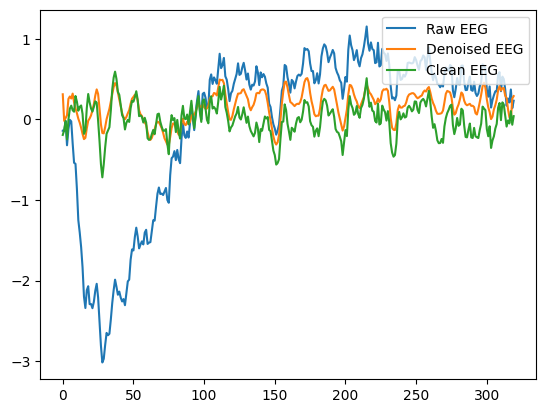

In [5]:
import os
import torch
import torch.utils.data as Data
import numpy as np
import matplotlib.pyplot as plt
#from network import DeepSeparator


model_name = 'DeepSeparator'

# choose one sample for visualization
index = 35

test_input = np.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/test_input.npy')
test_input = test_input[index]
test_output = np.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/test_output.npy')
test_output = test_output[index]

test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

test_input = torch.unsqueeze(test_input, 0)
test_output = torch.unsqueeze(test_output, 0)

test_torch_dataset = Data.TensorDataset(test_input)

print("torch.cuda.is_available() = ", torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = DeepSeparator()
model.to(device)

if os.path.exists('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/checkpoint/' + model_name + '.pkl'):
    print('load model')
    model.load_state_dict(torch.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/checkpoint/' + model_name + '.pkl'))


test_input = test_input.float().to(device)

extracted_signal = model(test_input, 0)  # 0 for denoising, 1 for extracting artifact
extracted_artifact = model(test_input, 1)  # 0 for denoising, 1 for extracting artifact


test_input_value = test_input.cpu()
test_input_value = test_input_value.detach().numpy()
test_input_value = test_input_value[0]

test_output_value = test_output.cpu()
test_output_value = test_output_value.detach().numpy()
test_output_value = test_output_value[0]

extracted_signal_value = extracted_signal.cpu()
extracted_signal_value = extracted_signal_value.detach().numpy()
extracted_signal_value = extracted_signal_value[0]

extracted_artifact_value = extracted_artifact.cpu()
extracted_artifact_value = extracted_artifact_value.detach().numpy()
extracted_artifact_value = extracted_artifact_value[0]

l0, = plt.plot(test_input_value)
l1, = plt.plot(extracted_signal_value)
# l2, = plt.plot(extracted_artifact_value)
l3, = plt.plot(test_output_value)


# plt.legend([l0, l1, l2, l3], ['Raw EEG', 'Denoised EEG', 'Extracted Artifact', 'Clean EEG'], loc='upper right')
plt.legend([l0, l1, l3], ['Raw EEG', 'Denoised EEG', 'Clean EEG'], loc='upper right')

plt.show()




